In [1]:
import os, re, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference
from nilearn import image
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.image import load_img, resample_to_img
from sklearn.model_selection import LeaveOneGroupOut
from nilearn.decoding import Decoder

In [2]:
BASE = "/local/anpa/ds003242-1.0.0"
DERIVATIVES = f"{BASE}/derivatives/"
DERIVATIVES_FMRIPREP = f"{DERIVATIVES}/fmriprep/" 
FIRST_LEVEL_SEP_RUNS = f"{DERIVATIVES}/firstlevel_separate_runs/"  
TASK = "CIC"
TR = 2.0

In [3]:
def resample_mask_to_bold(anat_mask, bold_img):
    """Resample anat mask to the space of the bold image.
    As in tutorial https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_first_level_details.html
    """
    return resample_to_img(
        anat_mask,
        bold_img,
        interpolation="nearest",
        copy_header=True,
        force_resample=True,
    )

def fprep_func_dir(sub):
    return Path(BASE)/f"derivatives/fmriprep/sub-{sub}/func"

In [4]:
all_sub_dirs = sorted([p.name.split("sub-")[-1] for p in Path(FIRST_LEVEL_SEP_RUNS).glob("sub-*") if p.is_dir()])
all_sub_dirs[:3]

['SAXSISO01b', 'SAXSISO01f', 'SAXSISO01s']

In [5]:
fasting_participants = [s for s in all_sub_dirs if s.endswith("f")]
social_participants = [s for s in all_sub_dirs if s.endswith("s")]
baseline_participants = [s for s in all_sub_dirs if s.endswith("b")]

In [6]:
fasting_food = [
    f
    for s in fasting_participants
    for f in Path(f"{FIRST_LEVEL_SEP_RUNS}/sub-{s}").rglob("*Food_*_zmap.nii.gz")]
fasting_social = [
    f
    for s in fasting_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
fasting_control = [
    f
    for s in fasting_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]


social_food = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Food_*_zmap.nii.gz")]
social_social = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
social_control = [
    f
    for s in social_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]


baseline_food = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Food_*_zmap.nii.gz")]
baseline_social = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Social_*_zmap.nii.gz")]
baseline_control = [
    f
    for s in baseline_participants
    for f in Path(f'{FIRST_LEVEL_SEP_RUNS}/sub-{s}').rglob("*Control_*_zmap.nii.gz")]

In [7]:
conditions = ['Food_1', 'Food_2', 'Food_3',
              'Social_1', 'Social_2', 'Social_3',
              'Control_1', 'Control_2', 'Control_3']

# 3 Classes, after fasting. CV folds based on runs (6)

In [8]:
runs_food = [str(f).split('/')[-1][0] for f in fasting_food]
labels_food  = ['Food']  * len (runs_food)

runs_social = [str(f).split('/')[-1][0] for f in fasting_social]
labels_social  = ['Social']  * len (runs_social)

runs_control = [str(f).split('/')[-1][0] for f in fasting_control]
labels_control  = ['Control']  * len (runs_control)

In [9]:
X = np.array(fasting_food + fasting_social + fasting_control)
y = np.array(labels_food + labels_social + labels_control)
groups = np.array(runs_food + runs_social + runs_control)

In [10]:
from collections import Counter
Counter(y), Counter(groups)

(Counter({'Food': 570, 'Social': 570, 'Control': 570}),
 Counter({'0': 288, '1': 288, '2': 288, '3': 288, '4': 279, '5': 279}))

In [11]:
decoder = Decoder(
    t_r=TR,
    estimator="svc",
    #mask=resampled_anat_mask,
    #mask_strategy = "whole-brain",
    standardize=False,
    #screening_percentile=5,
    cv=LeaveOneGroupOut(),
    scoring='accuracy',
    n_jobs=2
)
decoder.fit(X, y, groups)

Decoder(cv=LeaveOneGroupOut(), memory=Memory(location=None), n_jobs=2,
        scoring='accuracy', standardize=False, t_r=2.0)

In [12]:
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
print(
    f"Classification accuracy: {classification_accuracy:.4f} / "
)

# When standardize = True
#0.6713

Classification accuracy: 0.9011 / 


In [13]:
for label, scores in decoder.cv_scores_.items():
    print(label, np.mean(scores))

# When standardize = True
#Control 0.476926523297491
#Food 0.6126978793309438
#Social 0.9243951612903225

Control 0.8220392771804063
Food 0.9045512246117084
Social 0.9765905017921145


/tmp/ipykernel_538620/1232562512.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


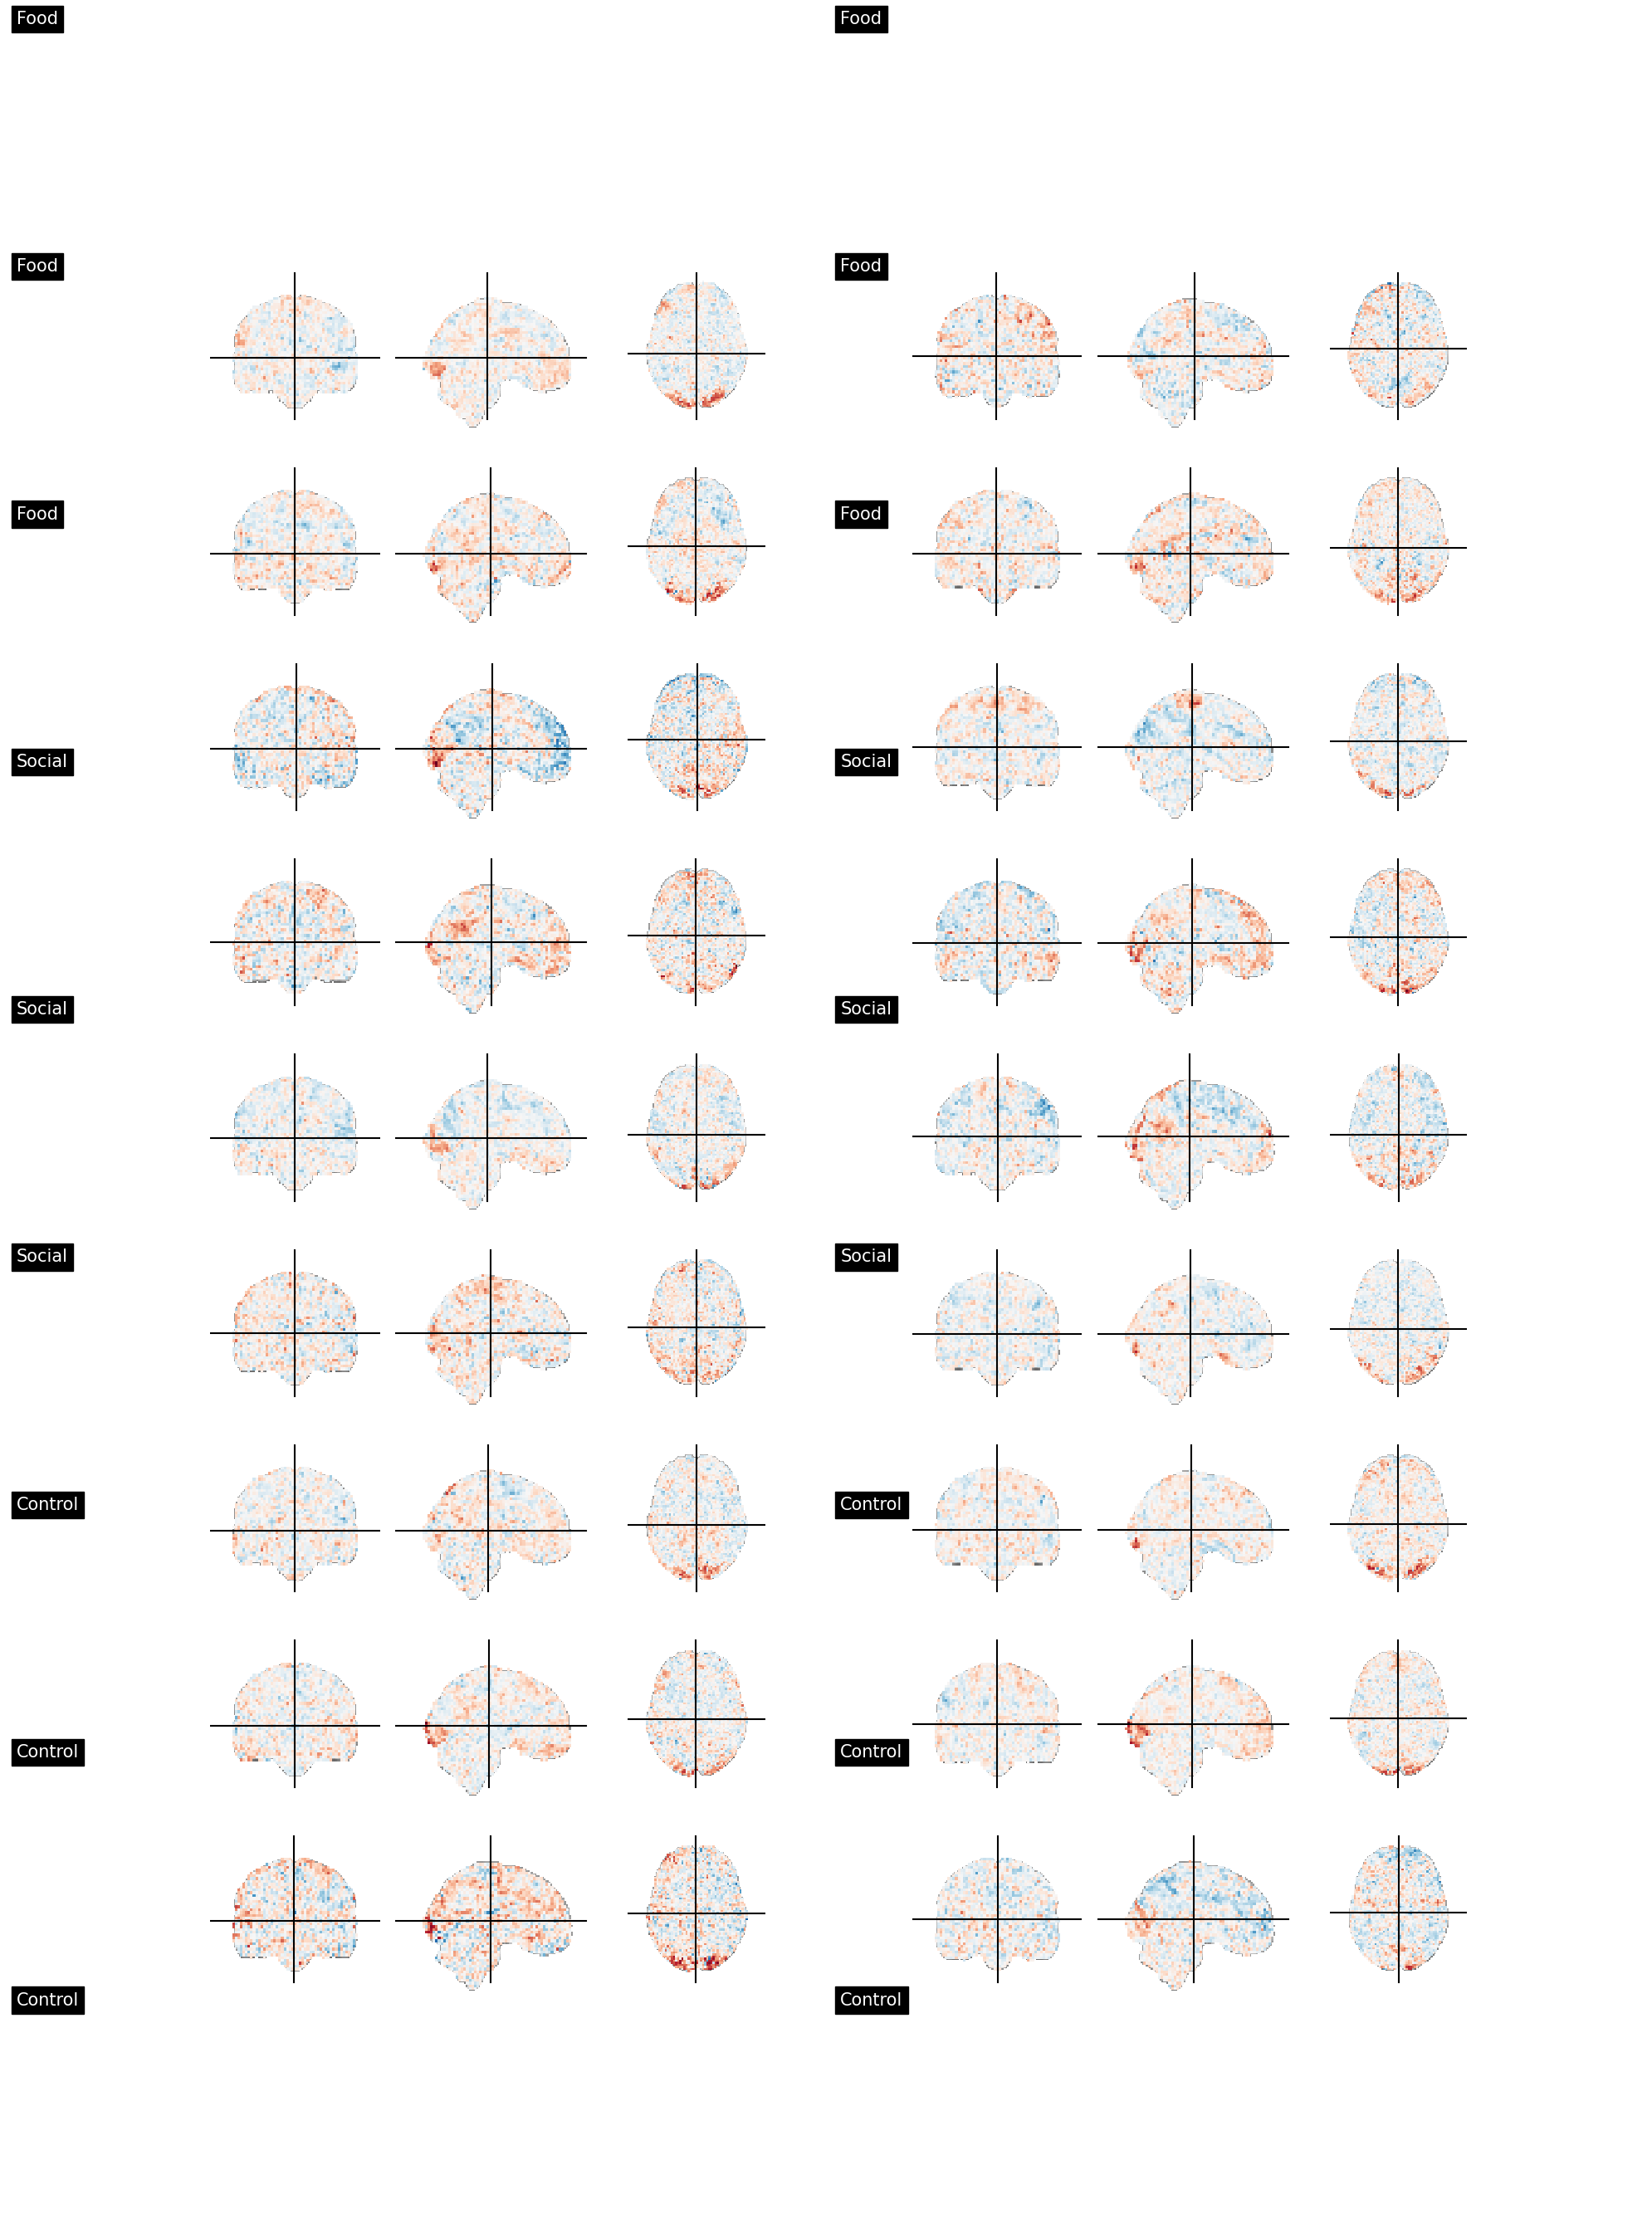

In [86]:
import random
from nilearn import plotting
import matplotlib.pyplot as plt

# Select 6 random files for each condition
food_samples = random.sample(fasting_food, 6)
social_samples = random.sample(fasting_social, 6)
control_samples = random.sample(fasting_control, 6)

samples = [
    ("Food", food_samples),
    ("Social", social_samples),
    ("Control", control_samples),
]

# Grid settings
n_cols = 2
n_per_task = 6
n_rows_per_task = n_per_task // n_cols   # = 3
total_rows = len(samples) * n_rows_per_task

fig, axes = plt.subplots(total_rows, n_cols, figsize=(20, 3*total_rows))

# Flatten axes (so we can index them linearly)
axes = axes.ravel()

plot_idx = 0
for task, files in samples:
    for img_file in files:
        ax = axes[plot_idx]
        plotting.plot_stat_map(
            img_file,
            display_mode="ortho",
            title=f"{task}",
            axes=ax,
            colorbar=False,
            annotate=False
        )
        plot_idx += 1

plt.tight_layout()
plt.show()

# 3 Classes during baseline

In [14]:
runs_food = [str(f).split('/')[-1][0] for f in baseline_food]
labels_food  = ['Food']  * len (runs_food)

runs_social = [str(f).split('/')[-1][0] for f in baseline_social]
labels_social  = ['Social']  * len (runs_social)

runs_control = [str(f).split('/')[-1][0] for f in baseline_control]
labels_control  = ['Control']  * len (runs_control)

In [15]:
X = np.array(baseline_food + baseline_social + baseline_control)
y = np.array(labels_food + labels_social + labels_control)
groups = np.array(runs_food + runs_social + runs_control)

In [16]:
decoder = Decoder(
    t_r=TR,
    estimator="svc",
    #mask=resampled_anat_mask,
    #mask_strategy = "whole-brain",
    standardize=False,
    #screening_percentile=5,
    scoring='accuracy',
    cv=LeaveOneGroupOut(),
    n_jobs=2
)
decoder.fit(X, y, groups)

Decoder(cv=LeaveOneGroupOut(), memory=Memory(location=None), n_jobs=2,
        scoring='accuracy', standardize=False, t_r=2.0)

In [17]:
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
print(
    f"Classification accuracy: {classification_accuracy:.4f} / "
)
# Classification accuracy: 0.6554

Classification accuracy: 0.8802 / 


In [18]:
for label, scores in decoder.cv_scores_.items():
    print(label, np.mean(scores))

# Control 0.4744623655913978
# Food 0.5675776583034647
# Social 0.924264486260454

Control 0.7961656212664278
Food 0.8741972819593787
Social 0.9702620967741935


# 3 Classes after social isolation

In [19]:
runs_food = [str(f).split('/')[-1][0] for f in social_food]
labels_food  = ['Food']  * len (runs_food)

runs_social = [str(f).split('/')[-1][0] for f in social_social]
labels_social  = ['Social']  * len (runs_social)

runs_control = [str(f).split('/')[-1][0] for f in social_control]
labels_control  = ['Control']  * len (runs_control)

In [20]:
X = np.array(social_food + social_social + social_control)
y = np.array(labels_food + labels_social + labels_control)
groups = np.array(runs_food + runs_social + runs_control)

In [21]:
decoder = Decoder(
    t_r=TR,
    estimator="svc",
    #mask=resampled_anat_mask,
    #mask_strategy = "whole-brain",
    standardize=False,
    scoring='accuracy',
    #screening_percentile=5,
    cv=LeaveOneGroupOut(),
    n_jobs=2
)
decoder.fit(X, y, groups)

Decoder(cv=LeaveOneGroupOut(), memory=Memory(location=None), n_jobs=2,
        scoring='accuracy', standardize=False, t_r=2.0)

In [22]:
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
print(
    f"Classification accuracy: {classification_accuracy:.4f} / "
)

#Classification accuracy: 0.6470

Classification accuracy: 0.8679 / 


In [23]:
for label, scores in decoder.cv_scores_.items():
    print(label, np.mean(scores))


# Control 0.4733796296296297
# Food 0.5376157407407408
# Social 0.929976851851852

Control 0.7748842592592592
Food 0.8564814814814815
Social 0.9722222222222222


# 3 Classes food predictions in different conditions 

In [24]:
runs_food_1 = [str(f).split('/')[-1][0] for f in fasting_food]
labels_food_1  = ['Food_1']  * len (runs_food_1)

runs_food_2 = [str(f).split('/')[-1][0] for f in social_food]
labels_food_2  = ['Food_2']  * len (runs_food_2)

runs_food_3 = [str(f).split('/')[-1][0] for f in baseline_food]
labels_food_3 = ['Food_3']  * len (runs_food_3)

In [25]:
X = np.array(fasting_food + social_food + baseline_food)
y = np.array(labels_food_1 + labels_food_2 + labels_food_3)
groups = np.array(runs_food_1 + runs_food_2 + runs_food_3)

In [26]:
decoder = Decoder(
    t_r=TR,
    estimator="svc",
    #mask=resampled_anat_mask,
    #mask_strategy = "whole-brain",
    standardize=False,
    #screening_percentile=5,
    cv=LeaveOneGroupOut(),
    scoring='accuracy',
    n_jobs=2
)
decoder.fit(X, y, groups)

Decoder(cv=LeaveOneGroupOut(), memory=Memory(location=None), n_jobs=2,
        scoring='accuracy', standardize=False, t_r=2.0)

In [27]:
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
print(
    f"Classification accuracy: {classification_accuracy:.4f} / "
)

# Classification accuracy: 0.6189

Classification accuracy: 0.8496 / 


In [28]:
for label, scores in decoder.cv_scores_.items():
    print(label, np.mean(scores))


# Food_1 0.6352070890879681
# Food_2 0.5979744722325909
# Food_3 0.6234247335241176

Food_1 0.8544887447638008
Food_2 0.8444728287918378
Food_3 0.8498229542532454


# 3 Classes social predictions in different conditions 

In [29]:
runs_social_1 = [str(f).split('/')[-1][0] for f in fasting_social]
labels_social_1  = ['Social_1']  * len (runs_social_1)

runs_social_2 = [str(f).split('/')[-1][0] for f in social_social]
labels_social_2  = ['Social_2']  * len (runs_social_2)

runs_social_3 = [str(f).split('/')[-1][0] for f in baseline_social]
labels_social_3 = ['Social_3']  * len (runs_social_3)

In [30]:
X = np.array(fasting_social + social_social + baseline_social)
y = np.array(labels_social_1 + labels_social_2 + labels_social_3)
groups = np.array(runs_social_1 + runs_social_2 + runs_social_3)

In [31]:
decoder = Decoder(
    t_r=TR,
    estimator="svc",
    #mask=resampled_anat_mask,
    #mask_strategy = "whole-brain",
    standardize=False,
    #screening_percentile=5,
    cv=LeaveOneGroupOut(),
    n_jobs=2
)
decoder.fit(X, y, groups)

Decoder(cv=LeaveOneGroupOut(), memory=Memory(location=None), n_jobs=2,
        standardize=False, t_r=2.0)

In [32]:
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
print(
    f"Classification accuracy: {classification_accuracy:.4f} / "
)

#Classification accuracy: 0.9115

Classification accuracy: 0.9408 / 


In [33]:
for label, scores in decoder.cv_scores_.items():
    print(label, np.mean(scores))

#Social_1 0.9085099316726643
#Social_2 0.9271546017834029
#Social_3 0.8986897429954035

Social_1 0.9410460602811913
Social_2 0.95401502918409
Social_3 0.927463936395633


In [34]:
decoder.predict(['/local/anpa/ds003242-1.0.0/derivatives/firstlevel_separate_runs/sub-SAXSISO08b/0_Social_2_effsize.nii.gz'])
#True label baseline = Social_3

array(['Social_2'], dtype='<U8')